In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn import preprocessing


import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# reads from csv into a new dataframe
raw_weather = pd.read_csv('weather_raw.csv',index_col=1)

# reindexes by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['']

# removes unused columns
raw_weather.drop(raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])],axis=1,inplace=True)

# renames columns
column_names = ['temp','tmin','tmax','pressure','humidity','wind','rain','snow','clouds']
raw_weather.columns = column_names

#reorders columns
raw_weather = raw_weather[['temp','tmin','tmax','pressure','humidity','wind','clouds','rain','snow']]

In [3]:
# drops duplicate rows
raw_weather.drop_duplicates(inplace=True)

In [4]:
# TEMPORARY bypass missing 2014-2015 data
weather = raw_weather.truncate('2016-01-01 00:00:00','2019-02-10 00:00:00')

In [5]:
# creates new index shifted by one position, used to calculate gap sizes
offbyone = raw_weather.iloc[raw_weather.index.get_loc(weather.index[0])-1:len(raw_weather.index)-1]

# create bool column indicating if a time gap is greater than six hours
# weather['impute_ok'] = weather.index - offbyone.index <= '06:00:00'

weather.insert(0,'impute_ok',(weather.index - offbyone.index <= '06:00:00'))


In [6]:
# reindexes to fill missing rows, for a total length of 27265
correct_dt = pd.DatetimeIndex(start='2016-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
weather = weather.reindex(index=correct_dt)

In [7]:
# fills gaps in data with True if less than 6 hours, False if more
weather['impute_ok'].fillna(method='bfill',inplace=True)

In [8]:
# removes weird wind outlier
weather['wind'] = weather['wind'].where(weather['wind'] < 20*weather['wind'].median())

# assigns NaN precip values to zero, this is an unconfirmed assumption
weather['rain'].replace(np.NaN,0,inplace=True)
weather['snow'].replace(np.NaN,0,inplace=True)

# removes negative clouds measurements
weather['clouds'].clip(lower=0,inplace=True)

# sets nonsense zeroes in temp, pressure, and humidity to NaN
weather.iloc[:,[0,1,2,3,4]] = weather.iloc[:,[0,1,2,3,4]].replace(0,np.NaN)

weather.describe()

# fn.snapshotplot(weather,'temp','2016-07-15 00:00:00','2016-07-25 00:00:00')

,temp,tmin,tmax,pressure,humidity,wind,clouds,rain,snow
count,25505.000000,25505.000000,25505.000000,25505.000000,25505.000000,25504.000000,25505.000000,27265.000000,27265.000000
mean,284.515651,282.245787,286.604817,1016.829876,70.902333,2.978748,41.812429,0.069799,0.002332
std,10.090681,10.227527,10.148530,8.172056,19.657567,1.865644,40.306978,0.529760,0.061998
min,251.790000,247.150000,255.150000,981.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,276.570000,274.150000,278.150000,1012.000000,56.000000,2.000000,1.000000,0.000000,0.000000
50%,284.520000,282.150000,286.450000,1017.000000,73.000000,3.000000,36.000000,0.000000,0.000000
75%,293.170000,291.150000,295.150000,1022.000000,88.000000,4.000000,90.000000,0.000000,0.000000
max,307.510000,305.370000,310.930000,1044.000000,100.000000,15.000000,100.000000,28.190000,4.000000


In [9]:
# imputes only values that have impute_ok = True
# in the future, try linear vs quadratic here
weather.mask(weather['impute_ok']==True, weather.interpolate(method='linear',limit=6), inplace=True)

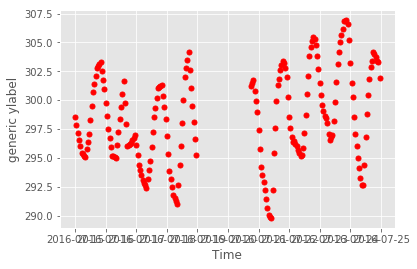

In [10]:
# plot over missing chunk to check that the simple impute has yielded expected results
fn.snapshotplot(weather,'temp','2016-07-15 00:00:00','2016-07-25 00:00:00')

In [11]:
# fn.gap_check(weather)

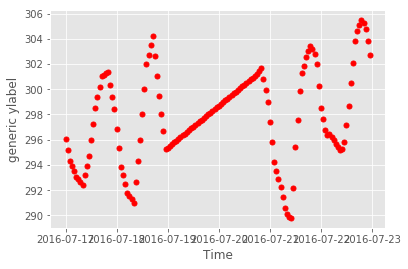

In [12]:
# imputes large segments, ignores period for now
# to be replaced by FFT imputation in the future

weather = weather.interpolate(method='linear')

# removes impute_ok column
weather.pop('impute_ok')

fn.snapshotplot(weather,'temp','2016-07-17 00:00:00','2016-07-23 00:00:00')

In [13]:
# this function adds columns with data from previous hours associated with the target hour
hours_before = np.arange(16,25)
weather_with_previous = fn.add_hours_before(weather,hours_before)
weather_with_previous.describe()

,temp,tmin,tmax,pressure,humidity,wind,clouds,rain,snow,temp-16,...,snow-23,temp-24,tmin-24,tmax-24,pressure-24,humidity-24,wind-24,clouds-24,rain-24,snow-24
count,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27249.000000,...,27242.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000
mean,284.324845,282.100423,286.364914,1016.727820,70.847075,2.973299,41.330167,0.069799,0.002332,284.329347,...,0.002334,284.331366,282.107230,286.371629,1016.727659,70.854551,2.973875,41.291840,0.069707,0.002334
std,10.057426,10.209560,10.115234,8.207584,19.704731,1.855066,40.087540,0.529760,0.061998,10.058595,...,0.062024,10.059373,10.211414,10.117046,8.210199,19.709036,1.855653,40.080833,0.529942,0.062025
min,251.790000,247.150000,255.150000,981.000000,8.000000,0.000000,0.000000,0.000000,0.000000,251.790000,...,0.000000,251.790000,247.150000,255.150000,981.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,276.410000,274.150000,278.150000,1012.000000,56.000000,2.000000,1.000000,0.000000,0.000000,276.410000,...,0.000000,276.400000,274.150000,278.150000,1012.000000,56.000000,2.000000,1.000000,0.000000,0.000000
50%,284.130000,282.150000,286.150000,1017.000000,73.000000,3.000000,29.333333,0.000000,0.000000,284.140000,...,0.000000,284.140000,282.150000,286.150000,1017.000000,73.000000,3.000000,28.000000,0.000000,0.000000
75%,292.960000,291.150000,295.150000,1022.000000,88.000000,4.000000,90.000000,0.000000,0.000000,292.960000,...,0.000000,292.960000,291.150000,295.150000,1022.000000,88.000000,4.000000,90.000000,0.000000,0.000000
max,307.510000,305.370000,310.930000,1044.000000,100.000000,15.000000,100.000000,28.190000,4.000000,307.510000,...,4.000000,307.510000,305.370000,310.930000,1044.000000,100.000000,15.000000,100.000000,28.190000,4.000000


In [15]:
# implements sklearn MinMaxScaler
x = weather_with_previous.values
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)

scaled = pd.DataFrame(x_scaled)
scaled.columns = weather_with_previous.columns

scaled.describe()

,temp,tmin,tmax,pressure,humidity,wind,clouds,rain,snow,temp-16,...,snow-23,temp-24,tmin-24,tmax-24,pressure-24,humidity-24,wind-24,clouds-24,rain-24,snow-24
count,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27265.000000,27249.000000,...,27242.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000,27241.000000
mean,0.583899,0.600316,0.559608,0.567108,0.683120,0.198220,0.413302,0.002476,0.000583,0.583980,...,0.000583,0.584016,0.600433,0.559728,0.567106,0.683202,0.198258,0.412918,0.002473,0.000583
std,0.180499,0.175362,0.181342,0.130279,0.214182,0.123671,0.400875,0.018792,0.015499,0.180520,...,0.015506,0.180534,0.175394,0.181374,0.130321,0.214229,0.123710,0.400808,0.018799,0.015506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.441852,0.463758,0.412334,0.492063,0.521739,0.133333,0.010000,0.000000,0.000000,0.441852,...,0.000000,0.441673,0.463758,0.412334,0.492063,0.521739,0.133333,0.010000,0.000000,0.000000
50%,0.580402,0.601168,0.555755,0.571429,0.706522,0.200000,0.293333,0.000000,0.000000,0.580581,...,0.000000,0.580581,0.601168,0.555755,0.571429,0.706522,0.200000,0.280000,0.000000,0.000000
75%,0.738873,0.755754,0.717103,0.650794,0.869565,0.266667,0.900000,0.000000,0.000000,0.738873,...,0.000000,0.738873,0.755754,0.717103,0.650794,0.869565,0.266667,0.900000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# scaled.to_csv('weather_clean.csv')

In [ ]:
# USEFUL STUFF

# # returns index labels where nan values appear for a certain column
# nan_index = weather['temp'].index[weather['temp'].apply(np.isnan)]
# nan_index

# correct and complete datetime index for the date range considered
# dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')

# # renames (here, makes lowercase) column labels using a simple loop
# df.columns = [x.lower() for x in df.columns]

# # implements sklearn scaler
# from sklearn import preprocessing
# x = df.values #returns a numpy array
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)